# 02 — Final Analysis and Paper Figures

Unisce i risultati da GTZAN (WITH_AUG/NO_AUG) e FMA per generare tabelle e figure finali.


## Panoramica del Notebook

Questo notebook aggrega i risultati dei vari work package e produce le figure finali per la consegna. Struttura:

- WP1 — Ablation: confronto con/ senza augmentation (GTZAN)
- WP2 — Efficienza: Params, FLOPs, Latenza vs Accuratezza
- WP3 — Cross-dataset (FMA Small): riepilogo
- WP4 — K-Fold su GTZAN: media ± std e per-fold
- Panoramica multi-dataset: GTZAN, INDIAN, TABLA — metriche aggregate
- Leaderboard e selezione del modello “champion”
- Deep-dive del champion: confusion matrix, classification report, t-SNE
- Galleria confusion matrices (se disponibili nei reports)

Note esecuzione:

- Il codice è in inglese; le spiegazioni sono in italiano.
- Il deep-dive usa CPU per evitare OOM e può riusare i risultati se già presenti (caching).

In [12]:
# Load summaries and configure paths (robust project root detection)
import os, sys, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from IPython.display import display

# Robustly locate PROJECT_ROOT by ascending until 'reports' directory is found
cwd = Path(os.getcwd()).resolve()
root = cwd
while root != root.parent and not (root/'reports').exists():
    root = root.parent
PROJECT_ROOT = root if (root/'reports').exists() else cwd.parent  # fallback one level up

# Paths
REPORTS = PROJECT_ROOT/'reports'
MODELS_PATH = PROJECT_ROOT/'models'
PROCESSED_GTZAN = PROJECT_ROOT/'data'/'processed'
PROCESSED_FMA = PROJECT_ROOT/'data'/'processed_fma'
PROCESSED_INDIAN = PROJECT_ROOT/'data'/'processed_indian'
PROCESSED_TABLA = PROJECT_ROOT/'data'/'processed_tabla'

# Styling
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.dpi'] = 100

print('Project root:', PROJECT_ROOT)
print('Reports directory:', REPORTS)

# Summary files
GTZAN_WITH = REPORTS/'training_summary_WITH_AUG.csv'
GTZAN_NO = REPORTS/'training_summary_NO_AUG.csv'
FMA_SUM = REPORTS/'training_summary_FMA.csv'
INDIAN_SUM = REPORTS/'training_summary_INDIAN.csv'
TABLA_SUM = REPORTS/'training_summary_TABLA.csv'
CV_SUM = REPORTS/'kfold_cv_unet_gtzan.csv'
CV_FOLDS = REPORTS/'kfold_cv_unet_gtzan_folds.csv'

# Load available summaries
dfs = {}
if GTZAN_WITH.exists(): dfs['WITH_AUG'] = pd.read_csv(GTZAN_WITH)
if GTZAN_NO.exists(): dfs['NO_AUG'] = pd.read_csv(GTZAN_NO)
if FMA_SUM.exists(): dfs['FMA'] = pd.read_csv(FMA_SUM)
if INDIAN_SUM.exists(): dfs['INDIAN'] = pd.read_csv(INDIAN_SUM)
if TABLA_SUM.exists(): dfs['TABLA'] = pd.read_csv(TABLA_SUM)
if CV_SUM.exists(): dfs['CV_SUM'] = pd.read_csv(CV_SUM)
if CV_FOLDS.exists(): dfs['CV_FOLDS'] = pd.read_csv(CV_FOLDS)

print('Loaded summaries:', ', '.join(dfs.keys()) if dfs else 'none found')

Project root: /home/alepot55/Desktop/projects/naml_project
Reports directory: /home/alepot55/Desktop/projects/naml_project/reports
Loaded summaries: WITH_AUG, NO_AUG, FMA, INDIAN, TABLA, CV_SUM, CV_FOLDS


## Setup and Data Discovery

In questa sezione configuriamo i percorsi, rileviamo automaticamente la root del progetto e carichiamo i riepiloghi disponibili. Tutto il codice, i commenti e le stampe sono in inglese per coerenza nella consegna.


,Model,Test_Accuracy_WITH_AUG,Test_Accuracy_NO_AUG,Gain_pp
2,UNet_Audio_Classifier,0.823,0.8180,0.500000
1,ResSE_AudioCNN,0.798,0.7990,-0.100005
0,Efficient_VGG,0.752,0.7535,-0.150001


Saved: /home/alepot55/Desktop/projects/naml_project/reports/wp1_ablation_with_vs_without_aug.csv


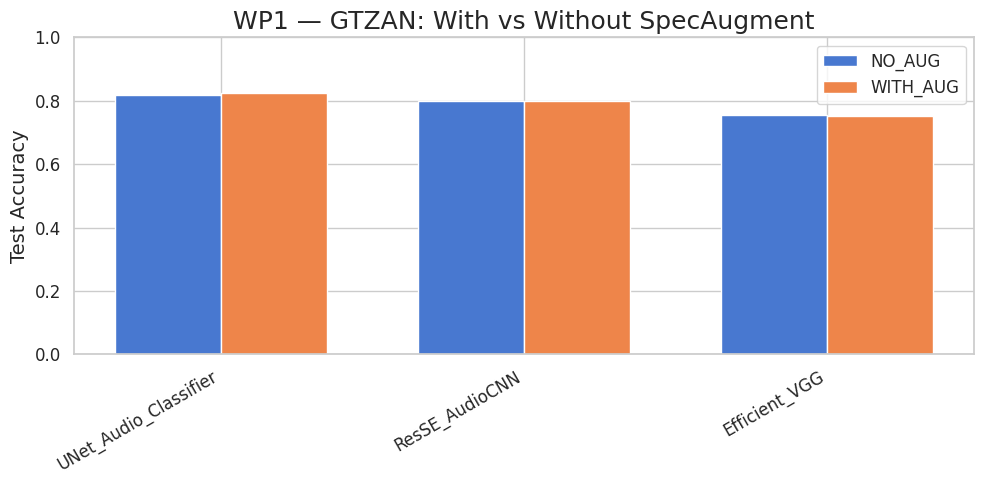

In [13]:
# WP1: Accuracy with vs without augmentation (GTZAN)
if 'WITH_AUG' in dfs and 'NO_AUG' in dfs:
    merged = pd.merge(dfs['WITH_AUG'][['Model','Test_Accuracy']],
                      dfs['NO_AUG'][['Model','Test_Accuracy']], on='Model',
                      suffixes=('_WITH_AUG','_NO_AUG'))
    if not len(merged):
        print('WP1: No overlapping models between WITH_AUG and NO_AUG summaries.')
    else:
        merged['Gain_pp'] = 100*(merged['Test_Accuracy_WITH_AUG']-merged['Test_Accuracy_NO_AUG'])
        merged = merged.sort_values('Gain_pp', ascending=False)
        display(merged)
        out_csv = REPORTS/'wp1_ablation_with_vs_without_aug.csv'
        merged.to_csv(out_csv, index=False)
        print('Saved:', out_csv)
        # Plot — paired bars
        plt.figure(figsize=(10,5))
        width = 0.35
        x = np.arange(len(merged['Model']))
        plt.bar(x - width/2, merged['Test_Accuracy_NO_AUG'], width, label='NO_AUG')
        plt.bar(x + width/2, merged['Test_Accuracy_WITH_AUG'], width, label='WITH_AUG')
        plt.xticks(x, merged['Model'], rotation=30, ha='right')
        plt.ylabel('Test Accuracy')
        plt.title('WP1 — GTZAN: With vs Without SpecAugment')
        plt.ylim(0,1.0)
        plt.legend()
        plt.tight_layout(); plt.show()
else:
    print('WP1: Missing results. Please run the GTZAN tournament with and without augmentation.')

## WP1 — Ablation on SpecAugment

Confrontiamo l'accuratezza test con e senza data augmentation (SpecAugment). Ci aspettiamo un piccolo guadagno in media; differenze troppo grandi possono indicare variabilità dovuta a random seed o split.


,Model,Params,Approx_FLOPs,Latency_ms,Test_Accuracy
2,UNet_Audio_Classifier,1176170,0.0,23.066792,0.823
1,ResSE_AudioCNN,1232770,0.0,26.752510,0.798
0,Efficient_VGG,34488,0.0,14.771867,0.752


Saved: /home/alepot55/Desktop/projects/naml_project/reports/wp2_efficiency_metrics.csv


/tmp/ipykernel_342024/3387602809.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1].set_title('FLOPs vs Test Accuracy'); axes[1].set_xscale('log')


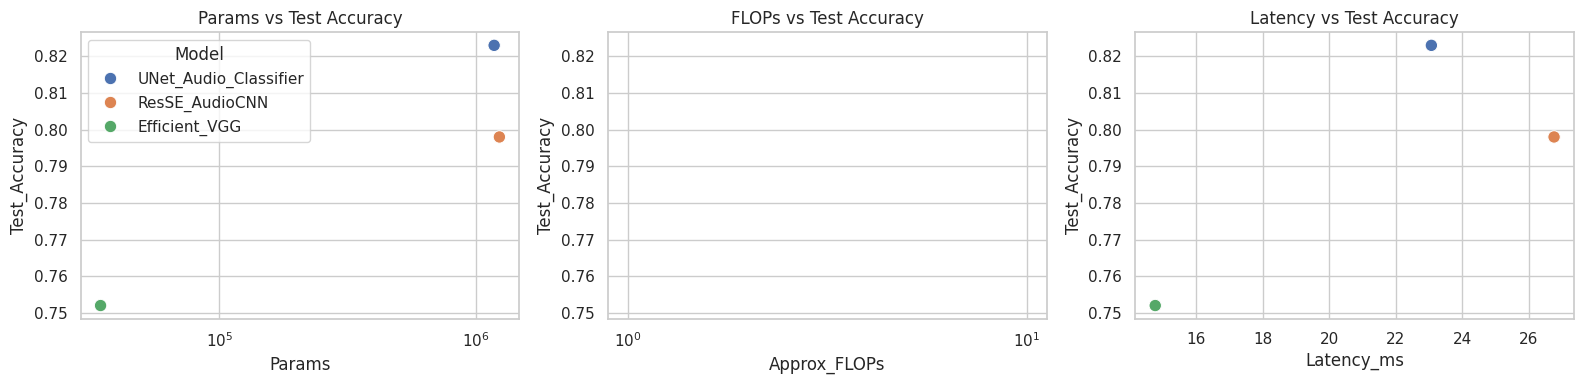

In [14]:
# WP2: Efficiency metrics table and plots (if present)
if 'WITH_AUG' in dfs:
    cols = ['Model','Params','Approx_FLOPs','Latency_ms','Test_Accuracy']
    if all(c in dfs['WITH_AUG'].columns for c in cols):
        eff = dfs['WITH_AUG'][cols].sort_values('Test_Accuracy', ascending=False)
        display(eff)
        out_csv = REPORTS/'wp2_efficiency_metrics.csv'
        eff.to_csv(out_csv, index=False)
        print('Saved:', out_csv)
        # Plots
        sns.set_theme(style='whitegrid')
        fig, axes = plt.subplots(1,3, figsize=(16,4))
        sns.scatterplot(ax=axes[0], data=eff, x='Params', y='Test_Accuracy', hue='Model', s=80)
        axes[0].set_title('Params vs Test Accuracy'); axes[0].set_xscale('log')
        sns.scatterplot(ax=axes[1], data=eff, x='Approx_FLOPs', y='Test_Accuracy', hue='Model', s=80, legend=False)
        axes[1].set_title('FLOPs vs Test Accuracy'); axes[1].set_xscale('log')
        sns.scatterplot(ax=axes[2], data=eff, x='Latency_ms', y='Test_Accuracy', hue='Model', s=80, legend=False)
        axes[2].set_title('Latency vs Test Accuracy')
        plt.tight_layout(); plt.show()
    else:
        print('WP2: Missing columns in WITH_AUG results. Re-run training with updated notebook to compute efficiency metrics.')
else:
    print('WP2: WITH_AUG results not found.')

## WP2 — Computational Efficiency

Confrontiamo parametri, FLOPs approssimati e latenza (batch=1) contro l'accuratezza. I valori dipendono dall'hardware; qui servono per confronto relativo tra architetture.


In [ ]:
# WP4: K-Fold CV results for UNet on GTZAN
if 'CV_SUM' in dfs:
    display(dfs['CV_SUM'])
    if 'CV_FOLDS' in dfs:
        print('Per-fold results:')
        display(dfs['CV_FOLDS'])
else:
    print('WP4: No K-Fold results found. Please run notebooks/gtzan/01c_kfold_unet.ipynb')

,Model,Dataset,K,ValAcc_Mean,ValAcc_Std
0,UNet_Audio_Classifier,GTZAN,5,0.904375,0.006835


Per-fold results:


,Fold,Val_Accuracy,Time_s
0,1,0.900625,152.923059
1,2,0.894375,145.697510
2,3,0.914375,147.913864
3,4,0.903750,174.203336
4,5,0.908750,122.072955


## WP4 — 5-Fold Cross-Validation on GTZAN (UNet)

Mostriamo la media e la deviazione standard dell'accuratezza di validazione sui 5 fold, più i risultati per-fold per verificare stabilità.


In [16]:
# WP3: FMA Small UNet results (if available)
if 'FMA' in dfs:
    display(dfs['FMA'])
else:
    print('Please run FMA notebooks to generate the summary (reports/training_summary_FMA.csv).')

,Model,Dataset,Best_Val_Accuracy,Test_Accuracy,Epochs_Run
0,UNet_Audio_Classifier,FMA_SMALL,0.485938,0.410937,62


## WP3 — Cross-Dataset Generalization (FMA Small)

Verifichiamo la capacità del modello UNet di generalizzare su un dataset diverso (FMA Small) mantenendo impostazioni audio coerenti. Inoltre, confrontiamo le prestazioni multi-dataset (GTZAN, INDIAN, TABLA) quando disponibili.

,Source,Model,Score
7,TABLA,UNet_Audio_Classifier,0.964912
2,WITH_AUG,UNet_Audio_Classifier,0.823000
5,NO_AUG,UNet_Audio_Classifier,0.818000
6,INDIAN,UNet_Audio_Classifier,0.722000
8,FMA,UNet_Audio_Classifier,0.410937


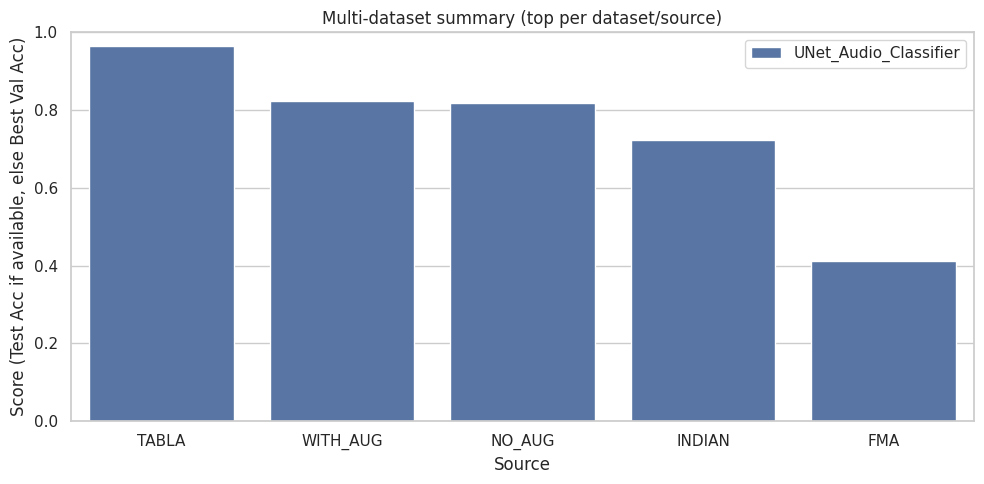

In [17]:
# Multi-dataset comparison (GTZAN champion vs INDIAN vs TABLA)
mdfs = []
for key in ['WITH_AUG','NO_AUG','INDIAN','TABLA','FMA']:
    if key in dfs:
        df = dfs[key].copy()
        df['Source'] = key
        # Ensure expected columns exist
        for col in ['Model', 'Test_Accuracy', 'Best_Val_Accuracy']:
            if col not in df.columns:
                df[col] = np.nan
        mdfs.append(df[['Source','Model','Test_Accuracy','Best_Val_Accuracy']].copy())

if mdfs:
    combined = pd.concat(mdfs, ignore_index=True)
    # Prefer Test_Accuracy, fallback to Best_Val_Accuracy
    combined['Score'] = combined['Test_Accuracy'].fillna(combined['Best_Val_Accuracy'])
    if combined.empty or combined['Score'].isna().all():
        print('No valid scores found across datasets.')
    else:
        # Keep only the top model per Source
        top_per_src = (combined
                       .sort_values('Score', ascending=False)
                       .drop_duplicates('Source', keep='first'))
        display(top_per_src[['Source','Model','Score']])

        plt.figure(figsize=(10,5))
        sns.barplot(data=top_per_src.sort_values('Score', ascending=False), x='Source', y='Score', hue='Model')
        plt.ylim(0, 1.0)
        plt.ylabel('Score (Test Acc if available, else Best Val Acc)')
        plt.title('Multi-dataset summary (top per dataset/source)')
        plt.legend(loc='best')
        plt.tight_layout(); plt.show()
else:
    print('No multi-dataset summaries found.')

In [18]:
# Identify champion model across available summaries (prefer Test_Accuracy)
champion_df, source, sort_col = None, None, None
for key in ['WITH_AUG', 'NO_AUG', 'INDIAN', 'TABLA', 'FMA']:
    if key in dfs:
        cols = dfs[key].columns
        if ('Test_Accuracy' in cols) or ('Best_Val_Accuracy' in cols):
            champion_df = dfs[key].copy()
            source = key
            sort_col = 'Test_Accuracy' if 'Test_Accuracy' in cols else 'Best_Val_Accuracy'
            break

if champion_df is None:
    raise RuntimeError('No summary found with expected columns. Please run the training notebooks.')

leaderboard = champion_df.sort_values(sort_col, ascending=False).reset_index(drop=True)
display(leaderboard)

champion_row = leaderboard.iloc[0]
champion_model_name = champion_row['Model']
champion_test_accuracy = champion_row['Test_Accuracy'] if 'Test_Accuracy' in champion_row.index else np.nan

print(f"Champion: {champion_model_name} (source: {source})")
if not np.isnan(champion_test_accuracy):
    print(f"Test Accuracy: {champion_test_accuracy:.4f}")

,Model,Tag,Best_Val_Accuracy,Test_Accuracy,Epochs_Run,Params,Approx_FLOPs,Latency_ms
0,UNet_Audio_Classifier,WITH_AUG,0.8525,0.823,73,1176170,0.0,23.066792
1,ResSE_AudioCNN,WITH_AUG,0.8155,0.798,55,1232770,0.0,26.752510
2,Efficient_VGG,WITH_AUG,0.7530,0.752,96,34488,0.0,14.771867


Champion: UNet_Audio_Classifier (source: WITH_AUG)
Test Accuracy: 0.8230


## Leaderboard and Champion Selection

Selezioniamo il miglior modello disponibile privilegiando GTZAN (WITH_AUG → NO_AUG) e poi FMA. L'ordinamento avviene su `Test_Accuracy` se presente, altrimenti su `Best_Val_Accuracy`.


In [ ]:
# WP4: K-Fold CV results for UNet on GTZAN
from pathlib import Path
folds_path = REPORTS / 'kfold_cv_unet_gtzan_folds.csv'
summary_path = REPORTS / 'kfold_cv_unet_gtzan.csv'
if not folds_path.exists() and not summary_path.exists():
    print('WP4: No K-Fold results found. Please run notebooks/gtzan/01c_kfold_unet.ipynb')
else:
    df_folds = None
    df_summary = None
    try:
        if folds_path.exists():
            df_folds = pd.read_csv(folds_path)
        if summary_path.exists():
            df_summary = pd.read_csv(summary_path)
    except Exception as e:
        print('Failed to read WP4 CSVs:', e)
        df_folds = None
        df_summary = None

    from IPython.display import display
    if df_summary is not None:
        print('WP4 (UNet 5-fold on GTZAN): Mean ± Std')
        display(df_summary)
    if df_folds is not None:
        print('Per-fold metrics:')
        display(df_folds)


Model loaded: UNet_Audio_Classifier_best_INDIAN.keras


Model: "UNet_Audio_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_conv1 (Conv2D)             │ (None, 128, 64, 32)    │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_bn1 (BatchNormalization)   │ (None, 128, 64, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_prelu1 (PReLU)             │ (None, 128, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_conv2 (Conv2D)             │ (None, 128, 64, 32)    │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_bn2 (BatchNormalization)   │ (None, 128, 64, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_prelu2 (PReLU)             │ (None, 128, 64, 32)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_pool (MaxPooling2D)        │ (None, 64, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_conv1 (Conv2D)             │ (None, 64, 32, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_bn1 (BatchNormalization)   │ (None, 64, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_prelu1 (PReLU)             │ (None, 64, 32, 64)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_conv2 (Conv2D)             │ (None, 64, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_bn2 (BatchNormalization)   │ (None, 64, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_prelu2 (PReLU)             │ (None, 64, 32, 64)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_pool (MaxPooling2D)        │ (None, 32, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_conv1 (Conv2D)             │ (None, 32, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_bn1 (BatchNormalization)   │ (None, 32, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_prelu1 (PReLU)             │ (None, 32, 16, 128)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_conv2 (Conv2D)             │ (None, 32, 16, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_bn2 (BatchNormalization)   │ (None, 32, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_prelu2 (PReLU)             │ (None, 32, 16, 128)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_pool (MaxPooling2D)        │ (None, 16, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bneck_conv1 (Conv2D)            │ (None, 16, 8, 256)     │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bneck_bn1 (BatchNormalization)  │ (None, 16, 8, 256)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bneck_prelu1 (PReLU)            │ (None, 16, 8, 256)     │           25

 Total params: 3,526,576 (13.45 MB)

 Trainable params: 1,174,885 (4.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2,349,771 (8.96 MB)

Cache hit: existing analysis artifacts found. Set FINAL_ANALYSIS_USE_CACHE=0 to recompute.


,Source,Macro_F1,Weighted_F1,File
0,WITH_AUG,0.8200,0.8200,classification_report_UNet_Audio_Classifier_WI...
1,INDIAN,0.7200,0.7200,classification_report_UNet_Audio_Classifier_IN...
2,TABLA,0.9594,0.9658,classification_report_UNet_Audio_Classifier_TA...
3,FMA,0.4000,0.4000,classification_report_UNet_Audio_Classifier_FM...


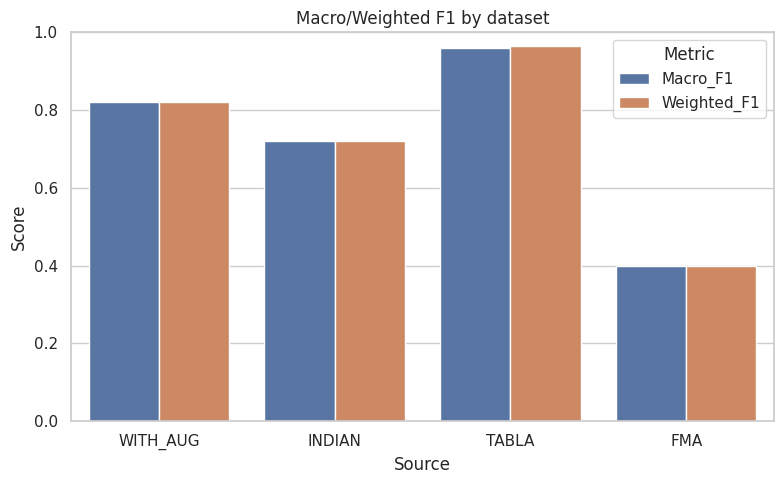

In [20]:
# Parse classification reports (macro-F1) for available datasets
from pathlib import Path

def parse_sklearn_classification_report(text: str):
    # Parse the last two lines (macro avg and weighted avg)
    lines = [ln.strip() for ln in text.strip().splitlines() if ln.strip()]
    macro_f1 = None
    weighted_f1 = None
    for ln in lines:
        if ln.lower().startswith('macro avg'):
            parts = [p for p in ln.split(' ') if p]
            # Expect: macro avg precision recall f1-score support
            try:
                macro_f1 = float(parts[-2])
            except Exception:
                pass
        if ln.lower().startswith('weighted avg'):
            parts = [p for p in ln.split(' ') if p]
            try:
                weighted_f1 = float(parts[-2])
            except Exception:
                pass
    return macro_f1, weighted_f1

cr_files = {
    'WITH_AUG': REPORTS/'classification_report_UNet_Audio_Classifier_WITH_AUG.txt',
    'INDIAN'  : REPORTS/'classification_report_UNet_Audio_Classifier_INDIAN.txt',
    'TABLA'   : REPORTS/'classification_report_UNet_Audio_Classifier_TABLA_TEST.txt',
    'FMA'     : REPORTS/'classification_report_UNet_Audio_Classifier_FMA.txt',
}

rows = []
for src, p in cr_files.items():
    if p.exists():
        try:
            txt = p.read_text()
            macro_f1, weighted_f1 = parse_sklearn_classification_report(txt)
            rows.append({'Source': src, 'Macro_F1': macro_f1, 'Weighted_F1': weighted_f1, 'File': p.name})
        except Exception as e:
            print('Parse failed for', p, '->', e)

if rows:
    f1df = pd.DataFrame(rows)
    display(f1df)
    plt.figure(figsize=(8,5))
    f1m = f1df.melt(id_vars=['Source'], value_vars=['Macro_F1','Weighted_F1'], var_name='Metric', value_name='Score')
    sns.barplot(data=f1m, x='Source', y='Score', hue='Metric')
    plt.ylim(0,1.0); plt.title('Macro/Weighted F1 by dataset'); plt.tight_layout(); plt.show()
else:
    print('No classification report files found to parse.')

## Champion Deep-Dive (Confusion Matrix, Report, t-SNE)

- Carichiamo il modello su CPU per evitare OOM o mismatch GPU/CPU.
- Sanity-check: ordiniamo le etichette della CM secondo il `label_encoder`.
- t-SNE su features di GlobalAveragePooling2D con sotto-campionamento bilanciato.
- Caching: se le figure e il report esistono già, possiamo saltare il ricalcolo (toggle).


/tmp/ipykernel_342024/480857202.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y='Model', data=df_sorted, palette='viridis', orient='h')


Saved: /home/alepot55/Desktop/projects/naml_project/reports/comparative_performance_barchart_WITH_AUG.png


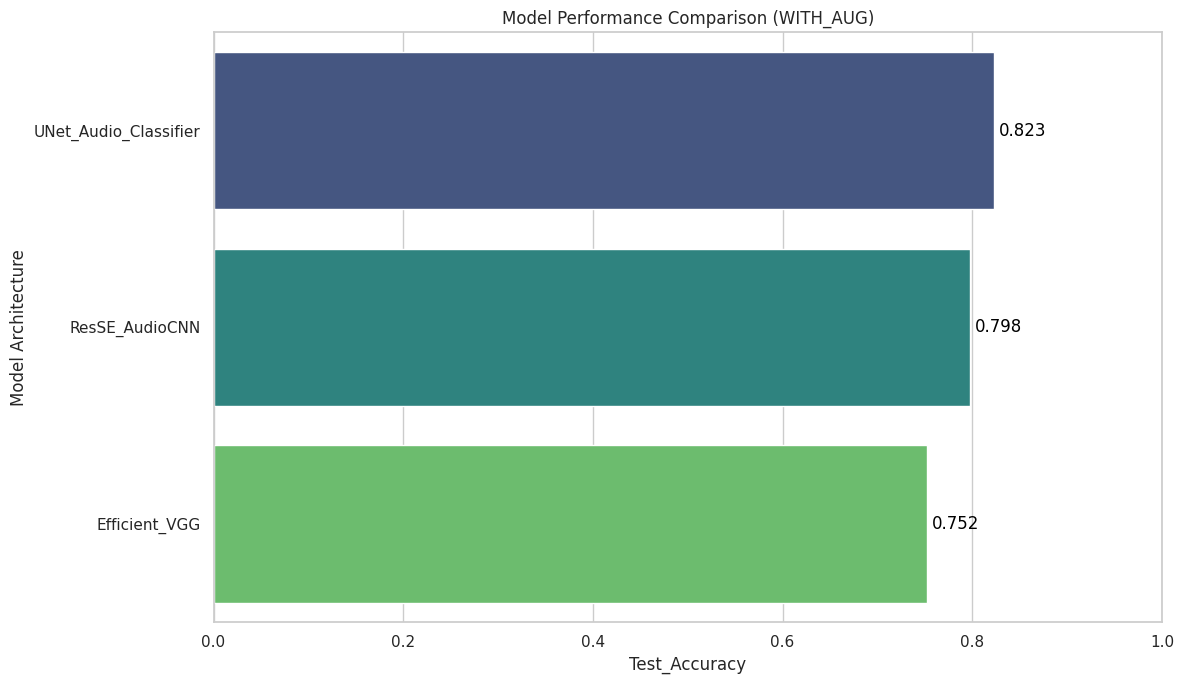

In [21]:
# Comparative performance bar chart for the selected summary
df_to_plot = leaderboard.copy()
metric = 'Test_Accuracy' if 'Test_Accuracy' in df_to_plot.columns else sort_col
df_sorted = df_to_plot.sort_values(metric, ascending=False)

if not metric:
    raise RuntimeError(f"Expected metric '{metric}' not found in the summary. Check the loaded data.")

plt.figure(figsize=(12,7))
ax = sns.barplot(x=metric, y='Model', data=df_sorted, palette='viridis', orient='h')
for i, row in df_sorted.reset_index(drop=True).iterrows():
    ax.text(row[metric] + (0.005 if metric.endswith('Accuracy') else 0.0), i, f"{row[metric]:.3f}", color='black', ha='left', va='center')
plt.title(f'Model Performance Comparison ({source})')
plt.xlabel(metric)
plt.ylabel('Model Architecture')
if metric.endswith('Accuracy'):
    plt.xlim(0, 1.0)
plt.tight_layout()
fig_path = REPORTS/f'comparative_performance_barchart_{source}.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print('Saved:', fig_path)
plt.show()

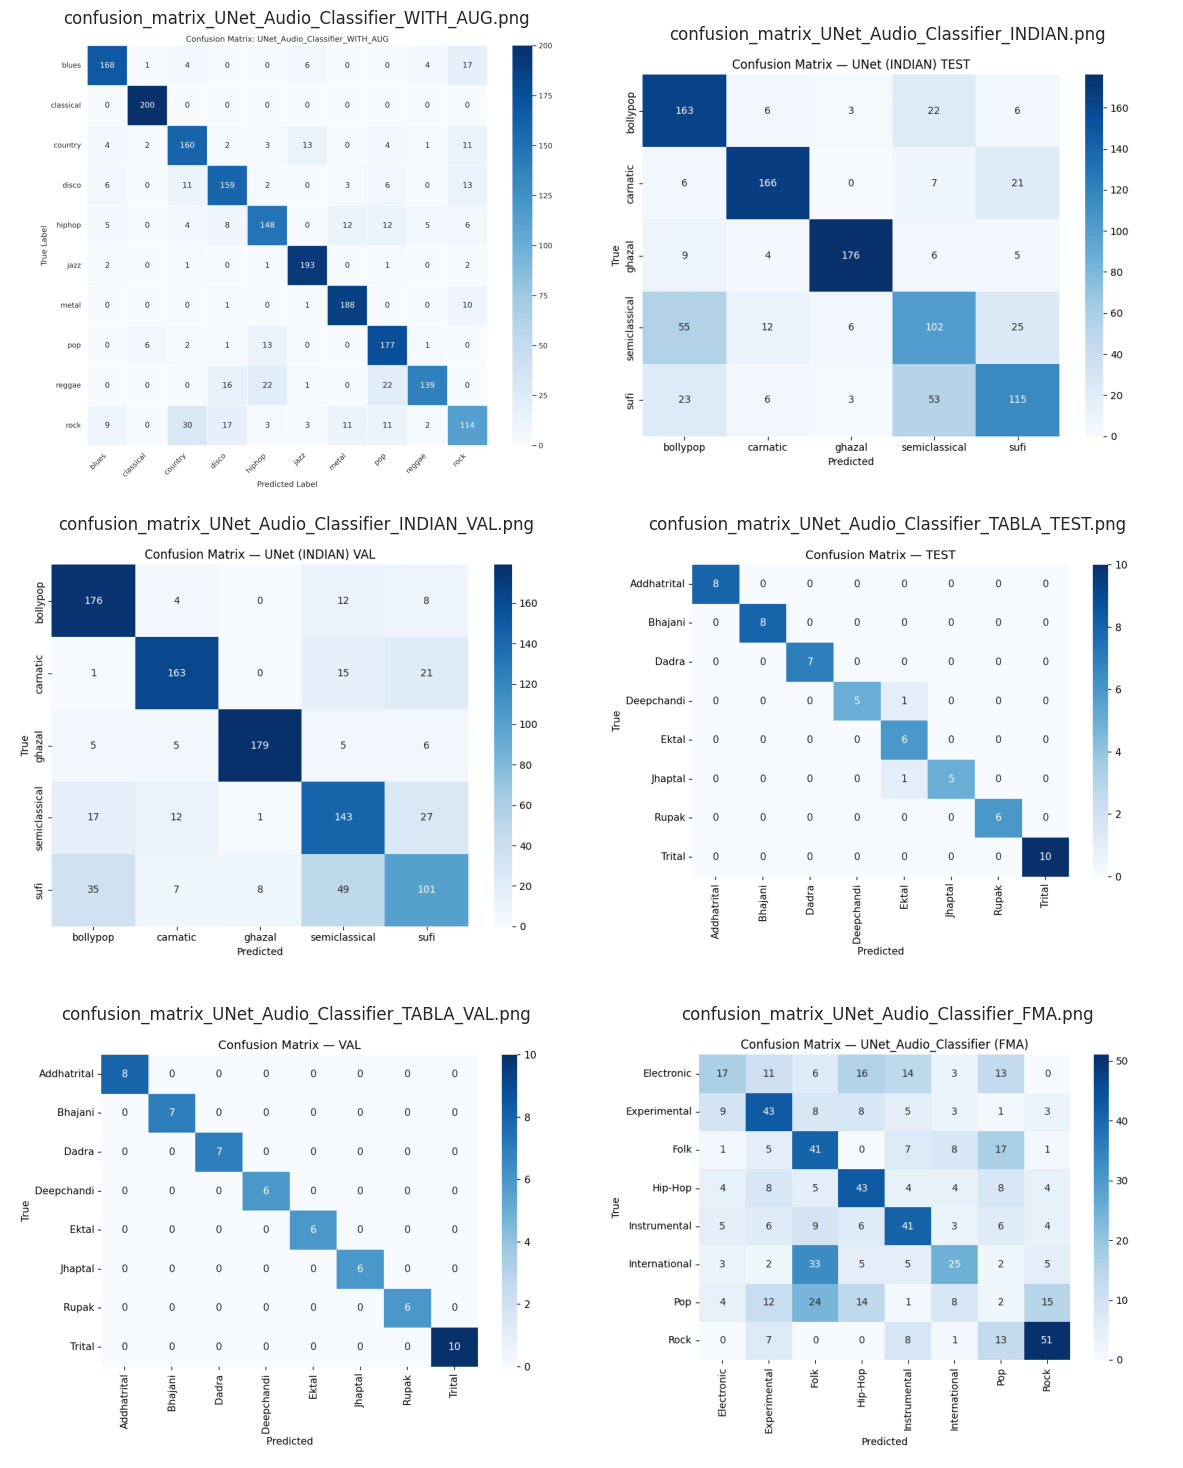

In [22]:
# Confusion matrix gallery (load existing PNGs if present)
from itertools import chain
cm_candidates = [
    REPORTS/'confusion_matrix_UNet_Audio_Classifier_WITH_AUG.png',
    REPORTS/'confusion_matrix_UNet_Audio_Classifier_INDIAN.png',
    REPORTS/'confusion_matrix_UNet_Audio_Classifier_INDIAN_VAL.png',
    REPORTS/'confusion_matrix_UNet_Audio_Classifier_TABLA_TEST.png',
    REPORTS/'confusion_matrix_UNet_Audio_Classifier_TABLA_VAL.png',
    REPORTS/'confusion_matrix_UNet_Audio_Classifier_FMA.png',
]
cm_paths = [p for p in cm_candidates if p.exists()]

if cm_paths:
    n = len(cm_paths)
    cols = 2
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(12, 5*rows))
    for i, p in enumerate(cm_paths, 1):
        img = plt.imread(p)
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.set_title(p.name)
        ax.axis('off')
    plt.tight_layout(); plt.show()
else:
    print('No confusion matrix images found in reports/.')